# Cat2Cloud for HDF5 files

#### Installs and imports

In [1]:
#Install necessary libraries
# !pip install caterva2 blosc2 matplotlib requests aiohttp fsspec
#Imports
import blosc2
import requests
import caterva2 as cat2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os.path

plt.style.use('default')
plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams.update({'text.usetex': False, 'font.serif': ['cm'], 'font.size': 16})
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.style.use('seaborn-v0_8-paper')
SMALL_SIZE = 1
MEDIUM_SIZE = 2
BIGGER_SIZE = 3

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Download h5 data from url to local

In [2]:
dir_path = "kevlar"
response = requests.get(f"http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/{dir_path}.h5")
with open(f"{dir_path}.h5", mode="wb") as file:
    file.write(response.content)

#### Setup client connection to server (modify user credentials as necessary)

In [3]:
# url = "https://cat2.cloud/demo"
url = "http://localhost:8002"
client = cat2.Client(url, ('user@example.com', 'foobar11'))
myroot = client.get('@shared')  # shared so all project users have access
print(f"Before uploading and unfolding: {myroot.file_list}")

Before uploading and unfolding: ['kevlar.h5', 'kevlar/!_attrs_.b2nd', 'kevlar/entry/!_attrs_.b2nd', 'kevlar/entry/data/!_attrs_.b2nd', 'kevlar/entry/data/data.b2nd']


#### Upload and unfold the files to the server

In [4]:
local_address = f"{dir_path}.h5"
remote_address = myroot.name + '/' + local_address
apath = client.upload(local_address, remote_address)
bloscpath = client.unfold(apath)
print(f"After uploading and unfolding: {myroot.file_list}")

After uploading and unfolding: ['kevlar.h5', 'kevlar/!_attrs_.b2nd', 'kevlar/entry/!_attrs_.b2nd', 'kevlar/entry/data/!_attrs_.b2nd', 'kevlar/entry/data/data.b2nd']


### Part 1: Using the proxy data object

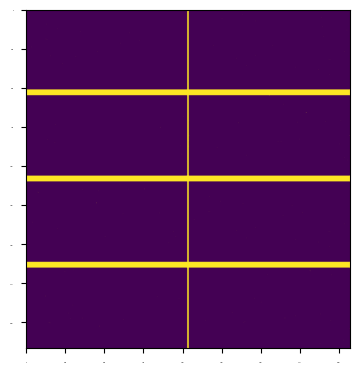

In [5]:
# Examine random frame of data
proxy = myroot["kevlar/entry/data/data.b2nd"]
cmap = plt.cm.viridis
example_image = proxy[5]
fig = plt.figure()
plt.imshow(example_image/65535, figure=fig, cmap=cmap, vmax=1, vmin=0)
# plt.show()

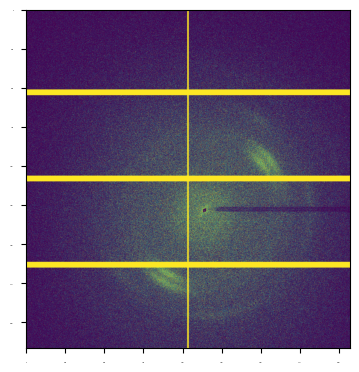

In [6]:
#Get an altered image that is more legible
remastered_image = client.lazyexpr("proxy_where", "where(a[5] < 10, a[5] * 32000, a[5])", {"a": proxy.path}, compute=True)
example_image = client.get(remastered_image)[:]/65535 # decompress locally
fig = plt.figure()
plt.imshow(example_image, figure=fig, cmap=cmap, vmax=1, vmin=0)

In [7]:
#Make a wee video - takes around 7s to load
import matplotlib.animation as animation
fig = plt.figure()
ax = fig.gca()
artists=[]
nframes=10
remastered_image = client.lazyexpr("proxy_where", f"where(a[:{nframes}] < 10, a[:{nframes}] * 20000, a[:{nframes}])", {"a": proxy.path}, compute=True)

for frame in range(nframes):
    example_image = client.get(remastered_image)[frame]/65535 # decompress locally
    im = ax.imshow(example_image, figure=fig, cmap=cmap, vmax=1, vmin=0)
    artists.append((im,))

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=200)
plt.close()
ani

### Part 2: Using a blosc2 array

In [8]:
 # copy 20 frames of data to blosc2 array on server
bloscfile = client.lazyexpr("kevlar20", f"a[:20]", {"a": proxy.path}, compute=True) #automatically stored in @personal root as @personal/kevlar20.b2nd

In [9]:
#Define lazyexpr that is saved but not executed - very quick
remastered_image = client.lazyexpr("blosc_where", "where(a < 10, a * 32000, a)", {"a": bloscfile}, compute=False)

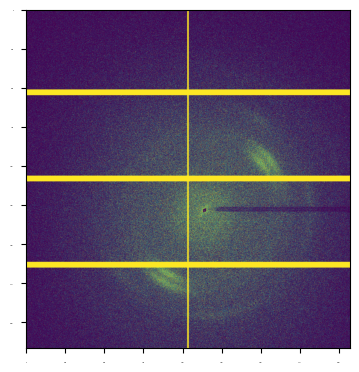

In [10]:
#Query a single image, execute lazyexpr on the fly
example_image = client.get(remastered_image)[5]/65535 # decompress locally
fig = plt.figure()
plt.imshow(example_image, figure=fig, cmap=cmap, vmax=1, vmin=0)

In [11]:
# Make the same video as before, but using the blosc2 array. Takes about 8s.
fig = plt.figure()
ax = fig.gca()
artists = []
nframes = 10
mylazy = client.get(remastered_image)
for frame in range(nframes):
    example_image = mylazy[frame] / 65535  # decompress locally
    im = ax.imshow(example_image, figure=fig, cmap=cmap, vmax=1, vmin=0)
    artists.append((im,))

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=200)
plt.close()
ani